### Package Installs and Imports

In [1]:
# %conda install -c conda-forge tweepy

In [2]:
import tweepy
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Data

The data used is from scraping the tweets of @WordleStats. API permissions (twitter api restricts the number of tweets that can be pulled per month) and hardware limitations prevent me from directly searching for all Wordle tweets myself. Implications of the dataset are discussed at the end of the data exploration section.

### Twitter Authetication

In [3]:
with open('credentials.json', 'r') as ifile:
    creds = json.load(ifile)

In [4]:
api_key = creds['api_key']
api_secret = creds['api_key_secret']
bearer_token = creds['bearer_token']
access_token = creds['access_token']
access_token_secret = creds['access_token_secret']

# Twitter API v.2 client authorization

client = tweepy.Client(bearer_token, api_key, api_secret, access_token, access_token_secret)

try:
    me = client.get_me()
    print(f"Authorized as {me.data}")
except:
    print("Authorization failed")


# Twitter API v.1 client authorization

# auth = tweepy.OAuth1UserHandler(api_key, api_secret, access_token, access_token_secret)
# api = tweepy.API(auth)

Authorized as william04dan


### Tweet Scraping


In [5]:
target_username = 'WordleStats'
target = client.get_users(usernames=[target_username])
target_id = target.data[0].id

Client.get_users_tweets() only retrieves a maximum of 100 tweets per request so to grab all tweets we need to repeatedly request tweets

In [6]:
target_tweets = client.get_users_tweets(id=target_id, max_results=100).data
latest_id = target_tweets[-1].id

while True:
    next_tweets = client.get_users_tweets(id=target_id, max_results=100, until_id=latest_id).data
    if not next_tweets:
        break
    target_tweets.extend(next_tweets)
    latest_id = target_tweets[-1].id

print(f"Grabbed {len(target_tweets)} tweets from @{target_username}\n")

Grabbed 381 tweets from @WordleStats



### Tweet Processing

In [7]:
example_tweet = target_tweets[0]
example_tweet

<Tweet id=1615031348976324613 text='#Wordle 575 2023-01-15\n24,058 results found on Twitter.\n2,310 hard mode players.\n\n1:  1%\n2: 🟩🟩🟩 15%\n3: 🟩🟩🟩🟩🟩🟩🟩🟩🟩 36%\n4: 🟩🟩🟩🟩🟩🟩 26%\n5: 🟩🟩🟩 14%\n6: 🟩 7%\nX:  2%\n\n#Wordle575'>

In [8]:
# Looking for the Wordle number
# For example, Wordle's autogenerated share message begins with 'Wordle #' where # is which number Wordle it is
wordle_pattern = re.compile(r'[wW]ordle\s?\d+')

# Looking for results found
results_pattern = re.compile(r'[\d,]+\sresults')

# Looking for hardmode players
hardmode_pattern = re.compile(r'[\d,]+\shard')

# Looking for the stats in WordleStat's tweets
stat_pattern = re.compile(r'\b[1-6xX]:.+\d%')

# Example processing of example_tweet
example_data = {}
wordle_match = wordle_pattern.search(example_tweet.text)
results_match = results_pattern.search(example_tweet.text)
hardmode_match = hardmode_pattern.search(example_tweet.text)
stats_matches = stat_pattern.finditer(example_tweet.text)

example_data['wordle_number'] = re.search(r'\d+', wordle_match[0])[0]
example_data['total_players'] = int(re.search(r'[\d,]+', results_match[0])[0].replace(',', ''))
example_data['hardmode_players'] = int(re.search(r'[\d,]+', hardmode_match[0])[0].replace(',', ''))
for match in stats_matches:
    example_data[f'score_{match[0][0]}'] = int(re.search(r'\d+', match[0][1:])[0]) / 100

example_data

{'wordle_number': '575',
 'total_players': 24058,
 'hardmode_players': 2310,
 'score_1': 0.01,
 'score_2': 0.15,
 'score_3': 0.36,
 'score_4': 0.26,
 'score_5': 0.14,
 'score_6': 0.07,
 'score_X': 0.02}

In [9]:
wordle_data = []
invalid_tweets = set()

for tweet in target_tweets:
    tweet_data = {}
    wordle_match = wordle_pattern.search(tweet.text)
    if not wordle_match:
        print(f'Did not find matching wordle_pattern in tweet {tweet.id}')
        invalid_tweets.add(tweet.id)
    else:
        tweet_data['wordle_number'] = re.search(r'\d+', wordle_match[0])[0]

    results_match = results_pattern.search(tweet.text)
    if not results_match:
        print(f'Did not find matching results_pattern in tweet {tweet.id}')
        invalid_tweets.add(tweet.id)
    else:
        tweet_data['total_players'] = int(re.search(r'[\d,]+', results_match[0])[0].replace(',', ''))

    hardmode_match = hardmode_pattern.search(tweet.text)
    if not hardmode_match:
        print(f'Did not find matching hardmode_pattern in tweet {tweet.id}')
        invalid_tweets.add(tweet.id)
    else:
        tweet_data['hardmode_players'] = int(re.search(r'[\d,]+', hardmode_match[0])[0].replace(',', ''))

    stats_matches = stat_pattern.finditer(tweet.text)
    scores = []
    for match in stats_matches:
        scores.append(match[0][0])
        tweet_data[f'score_{match[0][0]}'] = int(re.search(r'\d+', match[0][1:])[0]) / 100
    if len(scores) != 7:
        print(f'Only found data for {scores} in tweet {tweet.id}')
        invalid_tweets.add(tweet.id)

    if not tweet.id in invalid_tweets:
        wordle_data.append(tweet_data)

Did not find matching wordle_pattern in tweet 1488956933621129223
Did not find matching results_pattern in tweet 1488956933621129223
Did not find matching hardmode_pattern in tweet 1488956933621129223
Only found data for [] in tweet 1488956933621129223
Did not find matching wordle_pattern in tweet 1487826071357739008
Did not find matching results_pattern in tweet 1487826071357739008
Did not find matching hardmode_pattern in tweet 1487826071357739008
Only found data for [] in tweet 1487826071357739008
Did not find matching wordle_pattern in tweet 1486840170406158341
Did not find matching results_pattern in tweet 1486840170406158341
Did not find matching hardmode_pattern in tweet 1486840170406158341
Only found data for [] in tweet 1486840170406158341
Did not find matching wordle_pattern in tweet 1483455698038050820
Did not find matching results_pattern in tweet 1483455698038050820
Did not find matching hardmode_pattern in tweet 1483455698038050820
Only found data for [] in tweet 14834556

In [10]:
for tweet_id in invalid_tweets:
    tweet = client.get_tweet(id=tweet_id)
    print(tweet.data.text)

@CristinaAmpil What would an aggregate distribution look like? I’m unfamiliar with stats/etc
@Gary_Boyd_NZ Just for you for today Gary:

3,073 hard mode players.

1:  1%
2:  4%
3: 🟩🟩🟩 16%
4: 🟩🟩🟩🟩🟩🟩 27%
5: 🟩🟩🟩🟩🟩🟩🟩 30%
6: 🟩🟩🟩🟩 19%
X: 🟩 4%
@WordleHaiku These are the full results for everyone :)
@24Acoustics @PlanningActBlog You are correct! This should now be fixed.
@WordleHaiku Just for you for today!

132,770 results found on Twitter.
3,346 hard mode players.

1:  0.63%
2:  2.28%
3: 🟩🟩🟩 13.08%
4: 🟩🟩🟩🟩🟩🟩🟩 29.11%
5: 🟩🟩🟩🟩🟩🟩🟩 31.45%
6: 🟩🟩🟩🟩🟩 20.32%
X:  3.13%
@fudo @gooeyblob @WordleFRStats Yes, all players. I’ll see if adding the average makes sense, thanks!
@kyfdx Whole group


Looking through the above tweets, there isn't a large pattern of tweets misidentified. In fact, the only two tweets above containing contained Wordle data where additional side-tweets; they did not replace the daily stats. This is confirmed in the Data Exploration section.

In [11]:
# It makes more sense to reverse the data
wordle_df = pd.DataFrame(reversed(wordle_data))
wordle_df = wordle_df.set_index('wordle_number')
wordle_df.index = pd.to_numeric(wordle_df.index)

Finally, we load all Wordle words (up to February 04, 2023) into a list.

In [12]:
wordle_words = []

with open('wordle_words.txt', 'r') as fin:
    word_pattern = re.compile(r'[A-Z]{5}')
    for line in fin:
        wordle_words.append(word_pattern.search(line)[0])

wordle_words[:5]

['CIGAR', 'REBUT', 'SISSY', 'HUMPH', 'AWAKE']

### Data Exploration

Looking at the preview above, it seems that the earliest Wordle we have data on is Wordle 202. The latest is Wordle 575. We confirm this below.

In [13]:
print(f'The earliest recorded Wordle is Wordle {wordle_df.index.min()}')
print(f'The latest recorded Wordle is Wordle {wordle_df.index.max()}')

The earliest recorded Wordle is Wordle 202
The latest recorded Wordle is Wordle 575


Additionally, we can confirm that there are no Wordles skipped between 202 and 575. This confirms what we stated at the end of the previous section.

In [14]:
print(f'There are {len(wordle_df.index.unique())} distinct Wordles recorded')
print(f'There are {wordle_df.shape[0]} Wordles recorded')

There are 374 distinct Wordles recorded
There are 374 Wordles recorded


#### Let's look at player trends.

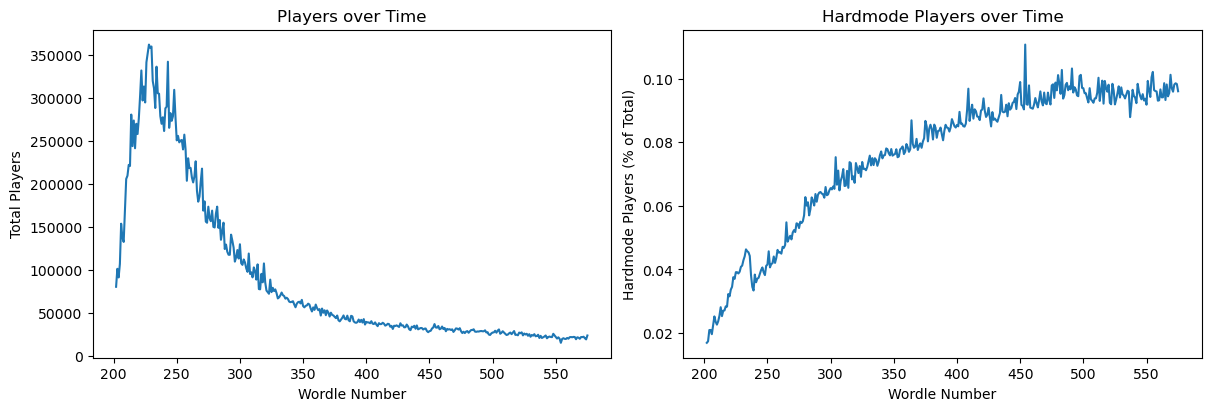

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), layout='constrained')

# Total players
axs[0].plot(wordle_df.index, wordle_df['total_players'])
axs[0].set_xlabel('Wordle Number')
axs[0].set_ylabel('Total Players')
axs[0].set_title('Players over Time')

# Hardmode players
axs[1].plot(wordle_df.index, wordle_df['hardmode_players'] / wordle_df['total_players'])
axs[1].set_xlabel('Wordle Number')
axs[1].set_ylabel('Hardmode Players (% of Total)')
axs[1].set_title('Hardmode Players over Time')
plt.show()

We observe that Wordle's popularity explodes at around Wordle 240 and has steadily fallen since then. This matches Wordle's virality at that time, and the steady decline since then matches the expected lifecycle of any game, especially one with a moment of virality like Wordle.

We can also observe that in this time Wordle's percentage of hardmode players has steadily increased. This may be explained by the idea that hardmode players are less likely to stop playing, and that as time goes on more players become better and discover hardmode.

#### Let's look at difficulty.

A natural way to determine the difficulty of a Wordle word is the average number of tries a user takes. This requires some decision-making.

1. Foremost is that the game ends after 6 tries. In reality, X tries can be 7, 8, or any number of tries. I choose to treat X tries as 7 tries. Given the distribution of tries this would be the most likely amount of tries X tries would correspond to. Also, as the amount of tries gets further from the average of 4 or 5, like 12 or 13, we might expect the score to be overly influenced by personal factors (such as knowing the target word, personal strategy) than the difficulty of the word.

2. Secondly, because we know how the game works, we know it is simply up to blind luck (or cheating) that a player gets the word in 1 try. Furthermore, the percentage is consistently close to 0%, and so it is unduly affected by the rounding done. I choose to exclude scores of 1 from my calculations.

In [16]:
def average_score(row):
    weighted = 0
    total = 0
    for score, score_col in enumerate(wordle_df.columns[3:], start=2):
        weighted += score * row[score_col]
        total += row[score_col]
    return weighted / total

average_scores = wordle_df.apply(average_score, axis=1)
print(f'The average difficulty of a Wordle is {average_scores.mean()}')

The average difficulty of a Wordle is 4.20259301044245


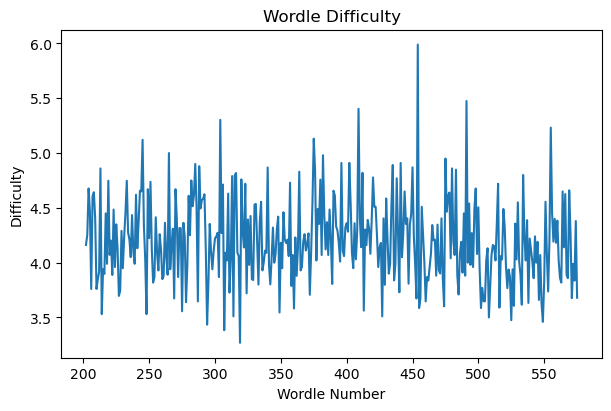

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')

# Total players
ax.plot(wordle_df.index, average_scores)
ax.set_xlabel('Wordle Number')
ax.set_ylabel('Difficulty')
ax.set_title('Wordle Difficulty')

plt.show()

Finally, let's find the three easiest Wordle words and the three hardest Wordle words.

In [18]:
TOP_X = 3

sorted_averages = average_scores.sort_values()
easiest_wordles = [sorted_averages.index[i] for i in range(TOP_X)]
hardest_wordles = [sorted_averages.index[-i] for i in range(1, TOP_X + 1)]

print(f'The {TOP_X} Easiest Wordles were:')
for i in range(TOP_X):
    print(f'Wordle {easiest_wordles[i]}: {wordle_words[easiest_wordles[i]]}')

print(f'The {TOP_X} Hardest Wordles were:')
for i in range(TOP_X):
    print(f'Wordle {hardest_wordles[i]}: {wordle_words[hardest_wordles[i]]}')

The 3 Easiest Wordles were:
Wordle 319: TRAIN
Wordle 307: PLANT
Wordle 294: STAIR
The 3 Hardest Wordles were:
Wordle 454: PARER
Wordle 491: MUMMY
Wordle 409: COYLY


The data we used is far from perfect. Someone else has aggregated the data, so we are relying on their accuracy. In addition, the percentages are rounded. It would be better to scrape the individual tweets ourselves to get a more exact distribution. If we had direct access to Wordle, we could get much more complete and unbaised data, like the actual number of players and scores, the scores of the people who share their scores, the number of people who start but do not complete their Wordle, etc.